# Subsampling Comparisons

In [23]:
import rioxarray as rxr
import geopandas as gpd
from shapely import unary_union

from gval import CatStats

## Create Subsampling DataFrame

Let's open up a geopackage with polygons to use for subsampling:

In [2]:
data_path = './'
polygons_continuous = gpd.read_file(f'{data_path}/subsample_continuous_polygons.gpkg')

To use this DataFrame as a subsampling DataFrame let's use `create_subsampling_df`:

In [3]:
polygons_continuous.gval.create_subsampling_df(subsampling_type=["include", "include"], inplace=True)
polygons_continuous

,geometry,subsample_type,subsample_id
0,"POLYGON ((-97.72375 29.56328, -97.72304 29.558...",include,1
1,"POLYGON ((-97.71604 29.55635, -97.71587 29.551...",include,2


The DataFrame above has a geometry column, a subsample type with the value of "include" (calculating data within the geometry) or "exclude" (remove all data contained within the geometry), and subsample_id.

There is also the ability to add subsampling_weights:

In [4]:
polygons_continuous = polygons_continuous.gval.create_subsampling_df(subsampling_type=["exclude", "exclude"], subsampling_weights=[2, 1])
polygons_continuous.explore()

## Continuous Compare Subsampling

In [5]:
cds = rxr.open_rasterio(f'{data_path}/candidate_continuous_1.tif', band_as_variable=True, mask_and_scale=True)
bds = rxr.open_rasterio(f'{data_path}/benchmark_continuous_1.tif', band_as_variable=True, mask_and_scale=True)

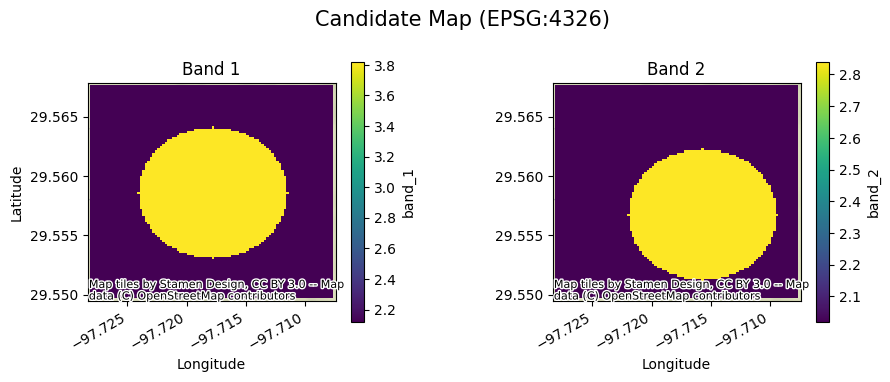

In [6]:
cds.gval.cont_plot(title="Candidate Map")

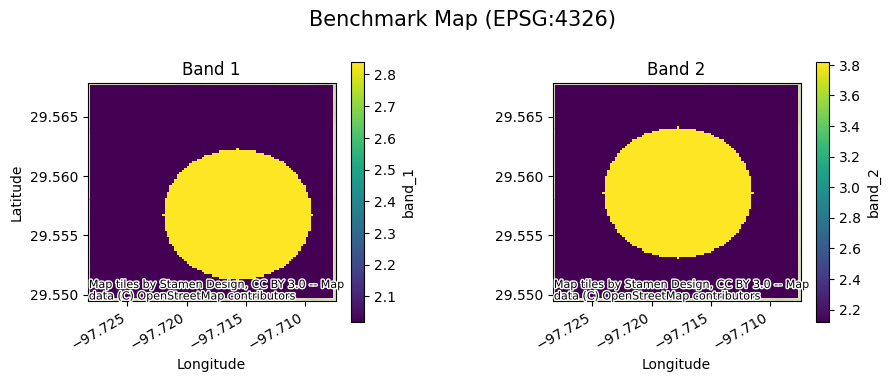

In [7]:
bds.gval.cont_plot(title="Benchmark Map")

Let's use this newly created subsampling dataframe on a continuous comparison.  For each subsample an agreement map is created and then used to calculate continuous statistics. There are four subsampling-average types:

1. <b>full-detail</b>: reports all metrics calculated on separate bands and subsamples.
2. <b>band</b>: reports all metrics on subsamples with band values averaged.
3. <b>subsample</b>: reports all metrics on bands with subsample values averaged.
4. <b>weighted</b>: reports all metrics on bands with subsample values averaged and scaled by weights.

#### Full-Detail

In [8]:
ag, met = cds.gval.continuous_compare(benchmark_map=bds,
                                      metrics=["mean_percentage_error"],
                                      subsampling_df=polygons_continuous,
                                      subsampling_average="full-detail")
met

,subsample,band,mean_percentage_error
0,1,1,0.125928
1,1,2,-0.111844
2,2,1,0.167116
3,2,2,-0.143187


The agreement maps for each subsample will look as follows:

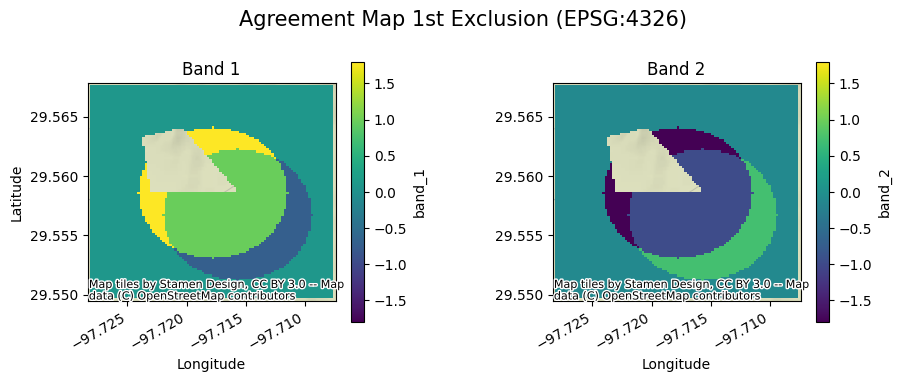

In [9]:
ag[0].gval.cont_plot(title="Agreement Map 1st Exclusion")

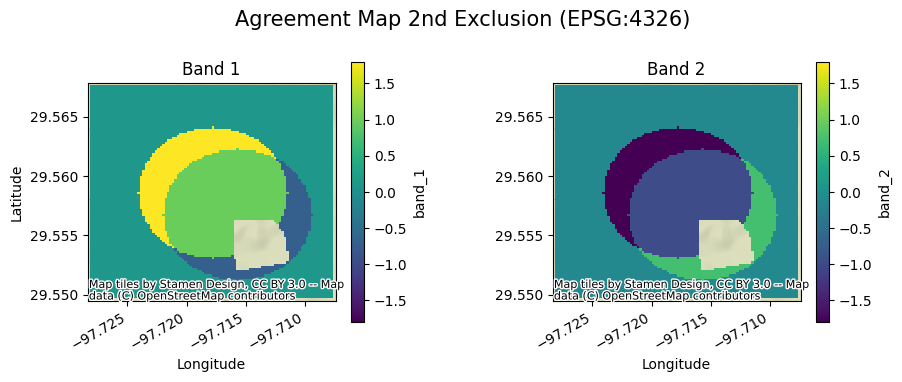

In [10]:
ag[1].gval.cont_plot(title="Agreement Map 2nd Exclusion")

#### Band

In [11]:
ag, met = cds.gval.continuous_compare(benchmark_map=bds,
                                      metrics=["mean_percentage_error"],
                                     subsampling_df=polygons_continuous,
                                     subsampling_average="band")
met

,subsample,band,mean_percentage_error
0,1,averaged,0.007042
1,2,averaged,0.011964


#### Subsample

In [12]:
ag, met = cds.gval.continuous_compare(benchmark_map=bds,
                                      metrics=["mean_percentage_error"],
                                     subsampling_df=polygons_continuous,
                                     subsampling_average="subsample")
met

,subsample,band,mean_percentage_error
0,averaged,1,0.146522
1,averaged,2,-0.127515


#### Weighted

In [13]:
ag, met = cds.gval.continuous_compare(benchmark_map=bds,
                                      metrics=["mean_percentage_error"],
                                      subsampling_df=polygons_continuous,
                                      subsampling_average="weighted")
met

,subsample,band,mean_percentage_error
0,averaged,1,0.083952
1,averaged,2,-0.037281


If one desires to have only one subsample with all of the exclusions combined use Shapely's `unary_union`:

In [29]:
combined_df = gpd.GeoDataFrame(geometry=[unary_union(polygons_continuous['geometry'])], 
                               crs=polygons_continuous.crs)
combined_df.gval.create_subsampling_df(subsampling_type=["exclude"], inplace=True)
ag, met = cds.gval.continuous_compare(benchmark_map=bds,
                                      metrics=["mean_percentage_error"],
                                      subsampling_df=combined_df,
                                      subsampling_average="full-detail")
met

,subsample,band,mean_percentage_error
0,1,1,0.133122
1,1,2,-0.117482


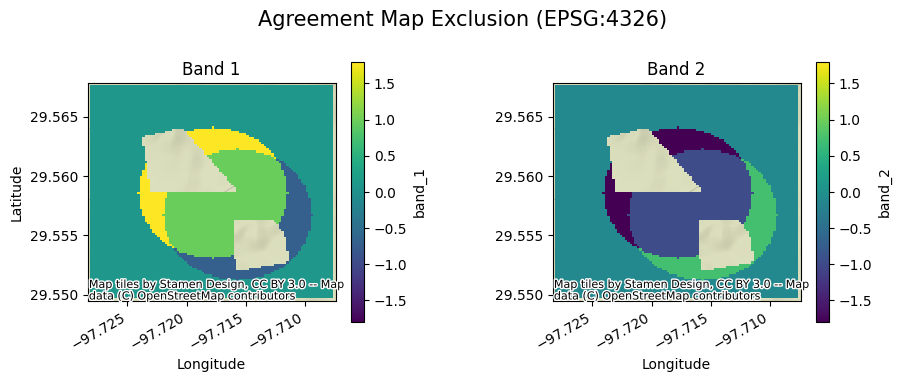

In [30]:
ag[0].gval.cont_plot(title="Agreement Map Exclusion")

## Categorical

In [14]:
# Subsampling DF
polygons_categorical = gpd.read_file(f'{data_path}/subsample_two-class_polygons.gpkg')
polygons_categorical.gval.create_subsampling_df(subsampling_type=["include", "include"], inplace=True)
polygons_categorical.explore()

In [15]:
# Candidate and Benchmark
cda = rxr.open_rasterio(f'{data_path}/candidate_map_multiband_two_class_categorical.tif', mask_and_scale=True)
bda = rxr.open_rasterio(f'{data_path}/benchmark_map_multiband_two_class_categorical.tif', mask_and_scale=True)

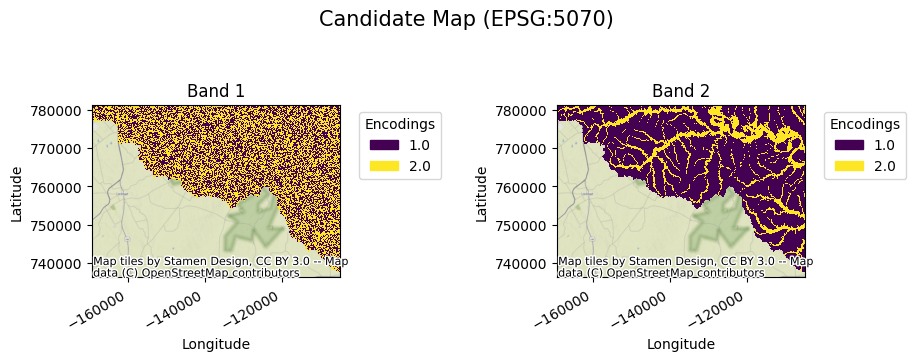

In [16]:
cda.gval.cat_plot("Candidate Map")

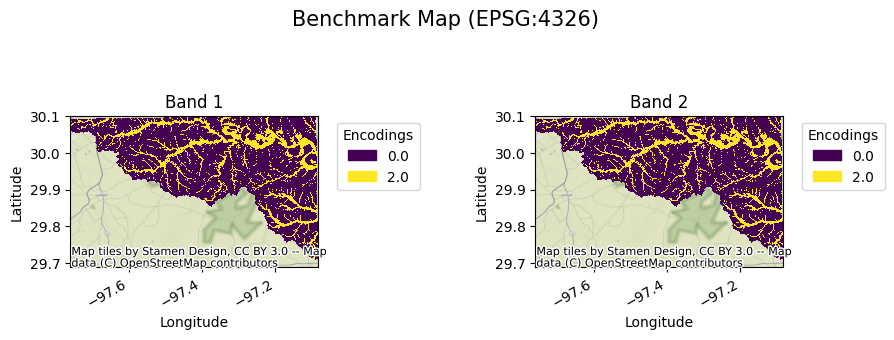

In [17]:
bda.gval.cat_plot("Benchmark Map")

Just as done earlier in continuous comparison, the following performs subsampling on categorical comparisons..  For each subsample an agreement map, a cross-tabulation table, and a metric table is created. There are three subsampling-average types:

1. <b>full-detail</b>: reports all metrics calculated on separate bands and subsamples.
2. <b>band</b>: reports all metrics on subsamples with band values averaged.
3. <b>subsample</b>: reports all metrics on bands with subsample values averaged.

#### Full-detail

In [18]:
ag, ctab, met = cda.gval.categorical_compare(benchmark_map=bda,
                                             metrics="all",
                                             positive_categories=[2],
                                             negative_categories=[0, 1],
                                             subsampling_df=polygons_categorical,
                                             subsampling_average="full-detail")
met.transpose()

,0,1,2,3
band,1,1,2,2
subsample,1,2,1,2
fn,201953.0,182389.0,68239.0,58638.0
fp,761242.0,397531.0,43646.0,65967.0
tn,762262.0,398338.0,1479858.0,729902.0
tp,201936.0,181301.0,335650.0,305052.0
accuracy,0.50026,0.499879,0.94195,0.892541
balanced_accuracy,0.500157,0.499506,0.901198,0.877941
critical_success_index,0.173316,0.238171,0.749997,0.70999
equitable_threat_score,0.000104,-0.000426,0.696008,0.602268


The agreement map will look as follows:

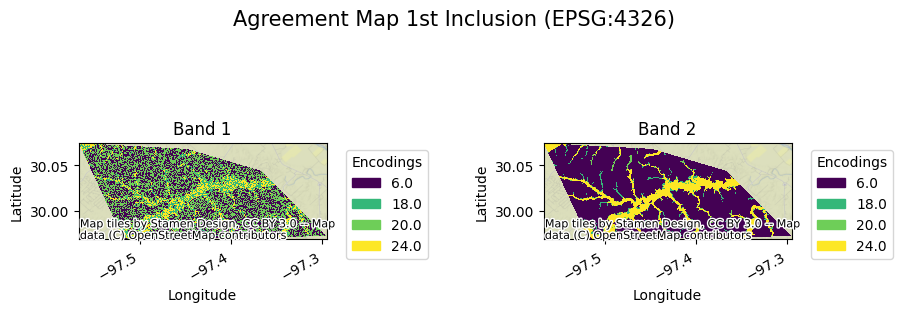

In [19]:
ag[0].gval.cat_plot(title="Agreement Map 1st Inclusion")

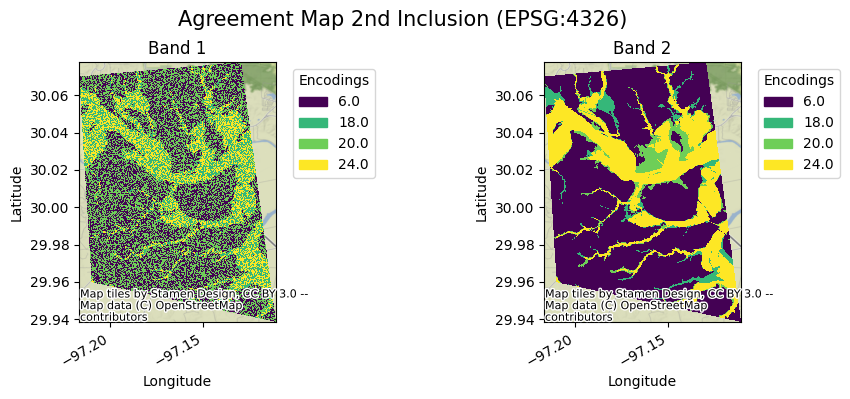

In [20]:
ag[1].gval.cat_plot(title="Agreement Map 2nd Inclusion")

#### Band

In [21]:
ag, ctab, met = cda.gval.categorical_compare(benchmark_map=bda,
                                             metrics="all",
                                             positive_categories=[2],
                                             negative_categories=[0, 1],
                                             subsampling_df=polygons_categorical,
                                             subsampling_average="band")
met.transpose()

,0,1
subsample,1,2
band,averaged,averaged
fn,270192.0,241027.0
fp,804888.0,463498.0
tn,2242120.0,1128240.0
tp,537586.0,486353.0
accuracy,0.721105,0.69621
balanced_accuracy,0.700678,0.688723
critical_success_index,0.333352,0.408399
equitable_threat_score,0.192488,0.211025


#### Subsample

In [22]:
ag, ctab, met = cda.gval.categorical_compare(benchmark_map=bda,
                                             metrics="all",
                                             positive_categories=[2],
                                             negative_categories=[0, 1],
                                             subsampling_df=polygons_categorical,
                                             subsampling_average="subsample")
met.transpose()

,0,1
subsample,averaged,averaged
band,1,2
fn,384342.0,126877.0
fp,1158773.0,109613.0
tn,1160600.0,2209760.0
tp,383237.0,640702.0
accuracy,0.500117,0.92339
balanced_accuracy,0.499837,0.893723
critical_success_index,0.198944,0.730401
equitable_threat_score,-0.000122,0.657571


As done earlier, if one wants to combine the inclusion of multiple polygons use `unary_union`:

In [34]:
combined_df = gpd.GeoDataFrame(geometry=[unary_union(polygons_categorical['geometry'])], 
                               crs=polygons_continuous.crs)
combined_df.gval.create_subsampling_df(subsampling_type=["include"], inplace=True)
ag, ctab, met = cda.gval.categorical_compare(benchmark_map=bda,
                                             metrics="all",
                                             positive_categories=[2],
                                             negative_categories=[0, 1],
                                             subsampling_df=combined_df,
                                             subsampling_average="full-detail")
met.transpose()

,0,1
band,1,2
subsample,1,1
fn,384342.0,126877.0
fp,1158773.0,109613.0
tn,1160600.0,2209760.0
tp,383237.0,640702.0
accuracy,0.500117,0.92339
balanced_accuracy,0.499837,0.893723
critical_success_index,0.198944,0.730401
equitable_threat_score,-0.000122,0.657571


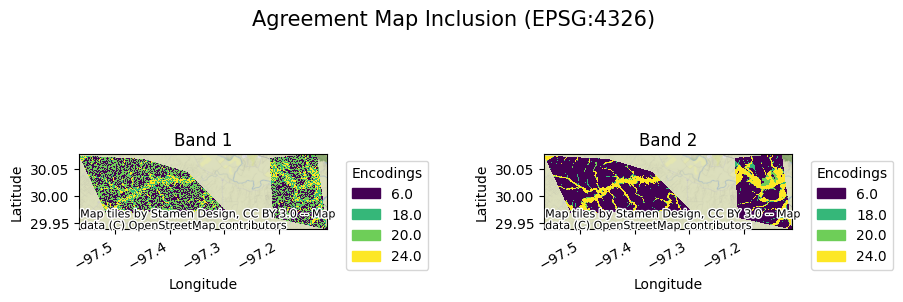

In [35]:
ag[0].gval.cat_plot(title="Agreement Map Inclusion")